<a href="https://colab.research.google.com/github/menglin874/BITM/blob/main/merge%20CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
## 加载所需要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
import seaborn as sns
import torch
import cv2

import tensorflow.keras.backend as K
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential,layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50



from keras.layers import Dense, Dropout, Activation, Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.models import Sequential
#from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import vgg16,vgg19

from sklearn.model_selection import train_test_split
from sklearn import metrics

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip /content/drive/MyDrive/Train_Validation.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: Train&Validation/valid/normal/normal2/normal2_patient321_SR_2_IM00016.tif  
  inflating: __MACOSX/Train&Validation/valid/normal/normal2/._normal2_patient321_SR_2_IM00016.tif  
  inflating: Train&Validation/valid/normal/normal2/normal2_patient331_SR_2_IM00010.tif  
  inflating: __MACOSX/Train&Validation/valid/normal/normal2/._normal2_patient331_SR_2_IM00010.tif  
  inflating: Train&Validation/valid/normal/normal2/normal2_patient275_SR_2_IM00023.tif  
  inflating: __MACOSX/Train&Validation/valid/normal/normal2/._normal2_patient275_SR_2_IM00023.tif  
  inflating: Train&Validation/valid/normal/normal2/normal2_patient275_SR_2_IM00037.tif  
  inflating: __MACOSX/Train&Validation/valid/normal/normal2/._normal2_patient275_SR_2_IM00037.tif  
  inflating: Train&Validation/valid/normal/normal2/normal2_patient265_SR_2_IM00019.tif  
  inflating: __MACOSX/Train&Validation/valid/normal/normal2/._normal2_patient265_SR_2_IM00019.tif  
  inflating: Train&Validatio

In [ ]:
! unzip /content/drive/MyDrive/COVID-CTset.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: COVID-CTset/normal6/patient394/SR_2/IM00036.tif  
  inflating: COVID-CTset/normal6/patient394/SR_2/IM00037.tif  
  inflating: COVID-CTset/normal6/patient394/SR_2/IM00038.tif  
  inflating: COVID-CTset/normal6/patient394/SR_2/IM00039.tif  
  inflating: COVID-CTset/normal6/patient394/SR_2/IM00040.tif  
  inflating: COVID-CTset/normal6/patient394/SR_2/IM00041.tif  
  inflating: COVID-CTset/normal6/patient394/SR_2/IM00042.tif  
  inflating: COVID-CTset/normal6/patient394/SR_2/IM00043.tif  
  inflating: COVID-CTset/normal6/patient394/SR_2/IM00044.tif  
  inflating: COVID-CTset/normal6/patient394/SR_2/IM00045.tif  
  inflating: COVID-CTset/normal6/patient394/SR_2/IM00046.tif  
  inflating: COVID-CTset/normal6/patient394/SR_2/IM00047.tif  
  inflating: COVID-CTset/normal6/patient394/SR_2/IM00048.tif  
  inflating: COVID-CTset/normal6/patient394/SR_2/IM00049.tif  
  inflating: COVID-CTset/normal6/patient394/SR_2/IM00050.tif  
  inflating: COVID-CTset/nor

In [ ]:
def extract_features(base_model,sample_count, datagen,feature_shape,labelclass):
    """
    base_model:用来提取特征的深度学习模型，如Xception(weights='imagenet',include_top=False)
    sample_count:需要生成的样本数量
    datagen:使用图片生成器ImageDataGenerator定义的数据集生成器
    feature_shape:每张图片最后转化的特征尺寸，如（5, 5, 2048）
    labelclass:数据集的类别数目
    """
    start = time()
    feature_shape2 = [i for i in feature_shape]# [12,12,512]
    feature_shape2.insert(0,sample_count)#在第一前加入一列计数=>[5229,12,12,512]
    features =  np.zeros(shape=tuple(feature_shape2))# 创建元组 features.shape = （5229,12,12,512）
    labels = np.zeros(shape=(sample_count,labelclass))# （5229，2）
    generator = datagen#我的数据库
    batch_size = generator.batch_size# batch size = 32
    i = 0
    for inputs_batch,labels_batch in generator:
        stop = time()
        times = stop - start
        print('\r',
              'Extracting features from batch', str(i+1), '/', len(datagen),
              '-- run time:', times,'seconds',
              end='')
        
        features_batch = base_model.predict(inputs_batch)
        #正常的.predict()输出的是分类结果概率，但是这里我们的模型去掉了分类器，所以可以输出结果就变成了最后一层池化后的结果。
        features[i * batch_size : (i + 1) * batch_size] = features_batch#每32个image为一个batchbatch，所以每32个替换一次
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch#没有任何操作，直接从原数据库复制过来，唯一需要注意的是与图像的对应问题
        i += 1
        
        if i * batch_size >= sample_count:
            break
            
    print("\n")
    return features,labels

In [ ]:
## 设置图像尺寸为150*150*3和batch_size=32
height=224
width=224
channels=3 
batch_size=64
seed = 1234

## 使用图片生成器ImageDataGenerator来准备训练集图像数据集
datagen = ImageDataGenerator(rotation_range = 30, ## 图片随机转动的角度
                             rescale=1. / 255,  ## 图像像素转化到0～1之间
                             shear_range=0.2,  ## 剪切强度
                             zoom_range=0.2, ## 随机缩放的幅度
                             horizontal_flip=True,## 随机水平翻转
                             vertical_flip=True,  ## 进行随机竖直翻转
                            )


## 从指定文件路径中读取训练数据集
train_data = datagen.flow_from_directory(directory="/content/TrainValidation/train", ## 数据文件路径
                                         target_size  = (height,width), ## 图像将被resize成该尺寸
                                         batch_size=batch_size, ##  batch数据的大小
                                         seed=seed,  ## 打乱数据和进行变换时的随机数种子
                                         class_mode="categorical", ## 该参数决定了返回的标签数组的形式,"categorical"会返回2D的one-hot编码标签,
                                        )
'''
train_data222 = datagen.flow_from_directory(directory="/content/TrainValidation/valid", ## 数据文件路径
                                         target_size  = (height,width), ## 图像将被resize成该尺寸
                                         batch_size=batch_size, ##  batch数据的大小
                                         seed=seed,  ## 打乱数据和进行变换时的随机数种子
                                         class_mode="categorical", ## 该参数决定了返回的标签数组的形式,"categorical"会返回2D的one-hot编码标签,
                                        )

                              '''

# 使用图片生成器ImageDataGenerator来准备测试集集图像
test_datagen = ImageDataGenerator(rescale=1./255)  ## 只将图像像素值转化到0～1之间
test_data = test_datagen.flow_from_directory(directory="/content/TrainValidation/valid", ## 数据文件路径
                                             target_size=(height,width), 
                                             batch_size=batch_size,
                                             seed=seed,
                                             class_mode="categorical")


Found 5229 images belonging to 2 classes.
Found 3417 images belonging to 2 classes.


In [ ]:
base_model1 = vgg19.VGG19(weights="imagenet",
                         include_top=False, ## 是否保留顶层的3个全连接网络
                         input_shape=(height,width,channels),## 输入层的尺寸
                        )
base_model1.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
featuresvgg1, test_labelsvgg1 = extract_features(base_model1,5229, train_data,(7,7,512),2)
#featuresvgg2, test_labelsvgg2 = extract_features(base_model1,8646, test_data,(7,7,512),2)


 Extracting features from batch 82 / 82 -- run time: 132.53941249847412 seconds



In [ ]:
features1 = np.reshape(featuresvgg1, (5229, -1))

#features2 = np.reshape(featuresvgg2, (8646, -1))


In [ ]:
#np.save("/content/drive/MyDrive/outputs/train_VGGfeatures3W.npy",features1)


In [ ]:
#features1=np.load("/content/drive/MyDrive/outputs/train_VGGfeatures.npy")

In [ ]:
## 建立全连接层神经网络
model1 = Sequential()
# model.add(Dense(1024,activation="relu",input_dim=train_features.shape[1],name = "fu_1"))  ## 添加全连接层
# model.add(Dropout(0.5))
model1.add(Dense(512,activation="relu",input_dim=features1.shape[1],name = "fu_1"))  ## 添加全连接层
model1.add(Dropout(0.5))
model1.add(Dense(256,activation="relu",name = "fu_2"))  ## 添加全连接层
model1.add(Dropout(0.25))
model1.add(Dense(2,activation="softmax",name = "fu_3"))  ## 添加softmax分类层
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fu_1 (Dense)                (None, 512)               12845568  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 fu_2 (Dense)                (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 fu_3 (Dense)                (None, 2)                 514       
                                                                 
Total params: 12,977,410
Trainable params: 12,977,410
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## 对模型进行编译和训练
model1.compile(Adam(lr=0.01),loss="categorical_crossentropy", metrics=["accuracy"])
## 通过fit_generator来对数据集进行训练
model_fit1 = model1.fit(features1, test_labelsvgg1,batch_size=32,
                      shuffle=True,validation_split=0.2,  ## 使用百分之10作为验证集
                      epochs=100, verbose=0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


        loss  accuracy  val_loss  val_accuracy  epochs
0   6.334427  0.685154  0.478186      0.777247       0
1   0.459674  0.785322  0.403737      0.839388       1
2   0.447091  0.800382  0.390986      0.845124       2
3   0.435530  0.804447  0.436481      0.847992       3
4   0.458191  0.798709  0.424524      0.812620       4
..       ...       ...       ...           ...     ...
95  0.519281  0.759503  0.345261      0.905354      95
96  0.552475  0.735836  0.355969      0.906310      96
97  0.503946  0.769304  0.371367      0.903442      97
98  0.511172  0.764284  0.386563      0.898662      98
99  0.523691  0.755678  0.355177      0.901530      99

[100 rows x 5 columns]


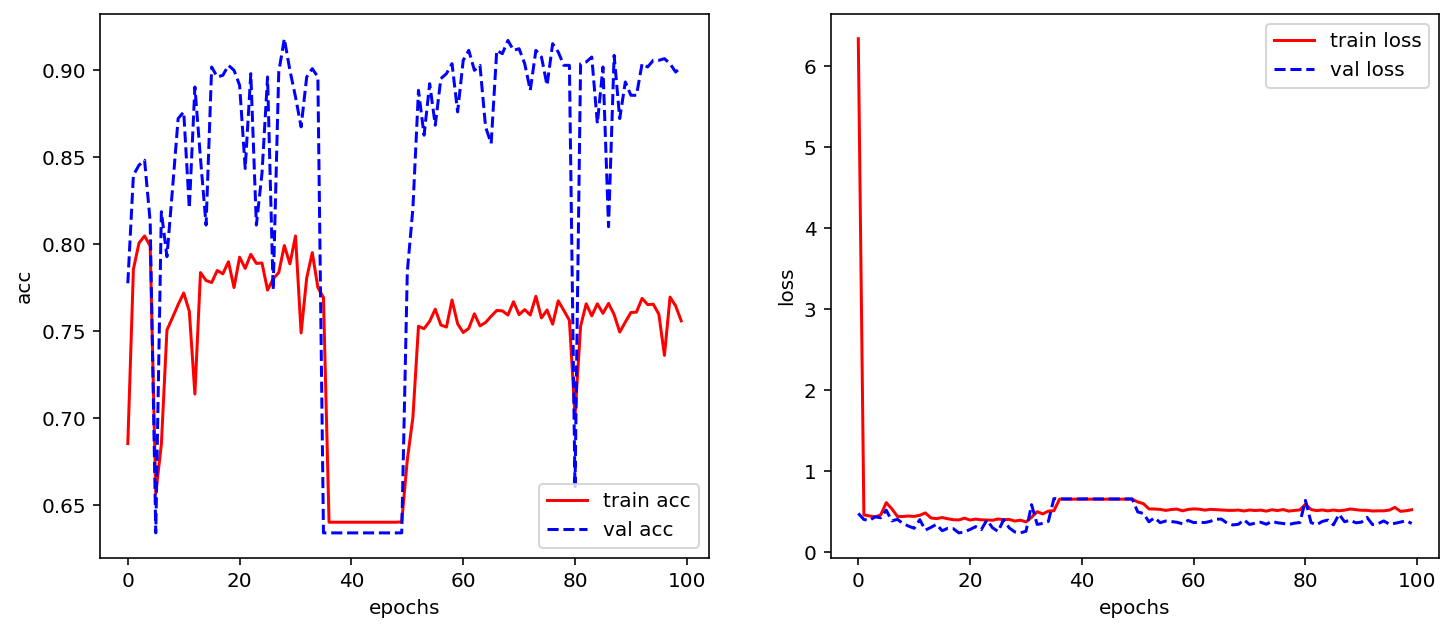

In [ ]:
# 将模型的结果可视化
model_accdf1 = pd.DataFrame(model_fit1.history)
model_accdf1["epochs"] = model_fit1.epoch
model_accdf1.head()

print(model_accdf1)

## 可视化acc 和loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(model_accdf1.epochs,model_accdf1.accuracy,"r-",label = "train acc")
plt.plot(model_accdf1.epochs,model_accdf1.val_accuracy,"b--",label = "val acc")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("acc")
plt.subplot(1,2,2)
plt.plot(model_accdf1.epochs,model_accdf1.loss,"r-",label = "train loss")
plt.plot(model_accdf1.epochs,model_accdf1.val_loss,"b--",label = "val loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:


## 建立全连接层神经网络
model4 = Sequential()
# model.add(Dense(1024,activation="relu",input_dim=train_features.shape[1],name = "fu_1"))  ## 添加全连接层
# model.add(Dropout(0.5))
model4.add(base_model1)
model4.add(tf.keras.layers.GlobalAveragePooling2D())

model4.add(Dense(512,activation="relu",name = "fu_1"))  ## 添加全连接层
model4.add(Dropout(0.5))
model4.add(Dense(256,activation="relu",name = "fu_2"))  ## 添加全连接层
model4.add(Dropout(0.25))

model4.add(Flatten())
model4.add(Dense(2,activation="softmax",name = "fu_3"))  ## 添加softmax分类层
model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 fu_1 (Dense)                (None, 512)               262656    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 fu_2 (Dense)                (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                      

In [ ]:
model4.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),loss="binary_crossentropy",metrics=["acc"])
model_fit4=model4.fit(train_data,
                      batch_size=64,
                      shuffle=True, #validation_split=0.,  ## 使用百分之10作为验证集
                      epochs=20, verbose=0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


        loss       acc  epochs
0   0.518978  0.738382       0
1   0.327786  0.869000       1
2   0.222026  0.911073       2
3   0.119652  0.956971       3
4   0.117377  0.959839       4
5   0.140394  0.952381       5
6   0.095655  0.967298       6
7   0.087003  0.972652       7
8   0.076029  0.974182       8
9   0.073256  0.978199       9
10  0.065040  0.977242      10
11  0.066179  0.977051      11
12  0.072247  0.974182      12
13  0.070224  0.975904      13
14  0.059645  0.978390      14
15  0.062388  0.978581      15
16  0.068487  0.976095      16
17  0.070426  0.975139      17
18  0.050531  0.982788      18
19  0.053719  0.983362      19


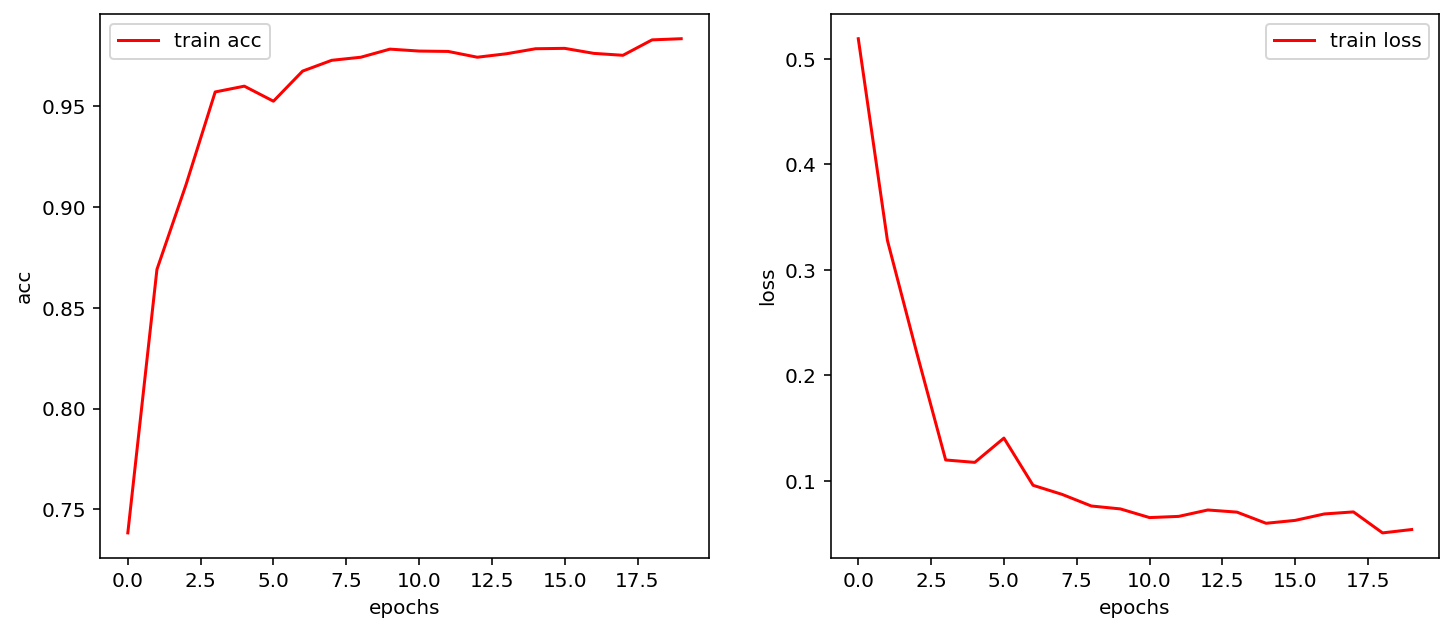

In [ ]:
## 将模型的结果可视化
model_accdf4 = pd.DataFrame(model_fit4.history)
model_accdf4["epochs"] = model_fit4.epoch
model_accdf4.head()

print(model_accdf4)

## 可视化acc 和loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(model_accdf4.epochs,model_accdf4.acc,"r-",label = "train acc")
#plt.plot(model_accdf.epochs,model_accdf.val_acc,"b--",label = "val acc")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("acc")
plt.subplot(1,2,2)
plt.plot(model_accdf4.epochs,model_accdf4.loss,"r-",label = "train loss")
#plt.plot(model_accdf.epochs,model_accdf.val_loss,"b--",label = "val loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
inputs = tf.keras.layers.Input(shape=(224,224,3))
combined = tf.keras.layers.Concatenate()([model4(inputs), model4(inputs)])
outputs = tf.keras.layers.Dense(2,activation="relu")(combined)

model_fin1= tf.keras.models.Model(inputs, outputs)



NameError: ignored

In [ ]:
model4.trainable = False
#model2.trainable = False

model_fin1.compile(Adam(lr=0.01),loss="categorical_crossentropy", metrics=["acc"])
modelfin1=model_fin1.fit(test_data,epochs=20)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
54/54 [==============================] - 46s 812ms/step - loss: 0.1739 - acc: 0.9526
Epoch 2/20
54/54 [==============================] - 43s 790ms/step - loss: 0.1805 - acc: 0.9558
Epoch 3/20
54/54 [==============================] - 44s 802ms/step - loss: 0.1781 - acc: 0.9567
Epoch 4/20
54/54 [==============================] - 43s 793ms/step - loss: 0.1333 - acc: 0.9541
Epoch 5/20
54/54 [==============================] - 44s 797ms/step - loss: 0.1285 - acc: 0.9564
Epoch 6/20
54/54 [==============================] - 44s 796ms/step - loss: 0.1258 - acc: 0.9561
Epoch 7/20
54/54 [==============================] - 44s 797ms/step - loss: 0.1406 - acc: 0.9552
Epoch 8/20
54/54 [==============================] - 44s 796ms/step - loss: 0.1233 - acc: 0.9584
Epoch 9/20
54/54 [==============================] - 44s 797ms/step - loss: 0.1116 - acc: 0.9573
Epoch 10/20
54/54 [==============================] - 44s 795ms/step - loss: 0.1129 - acc: 0.9590
Epoch 11/20
54/54 [====================

        loss       acc  epochs
0   0.173916  0.952590       0
1   0.180522  0.955809       1
2   0.178068  0.956687       2
3   0.133314  0.954053       3
4   0.128468  0.956394       4
5   0.125790  0.956102       5
6   0.140610  0.955224       6
7   0.123268  0.958443       7
8   0.111604  0.957272       8
9   0.112939  0.959028       9
10  0.127503  0.959028      10
11  0.144712  0.959028      11
12  0.131515  0.960492      12
13  0.121262  0.961077      13
14  0.118039  0.961370      14
15  0.113030  0.961077      15
16  0.113449  0.962248      16
17  0.110764  0.961370      17
18  0.109672  0.962833      18
19  0.110893  0.961370      19


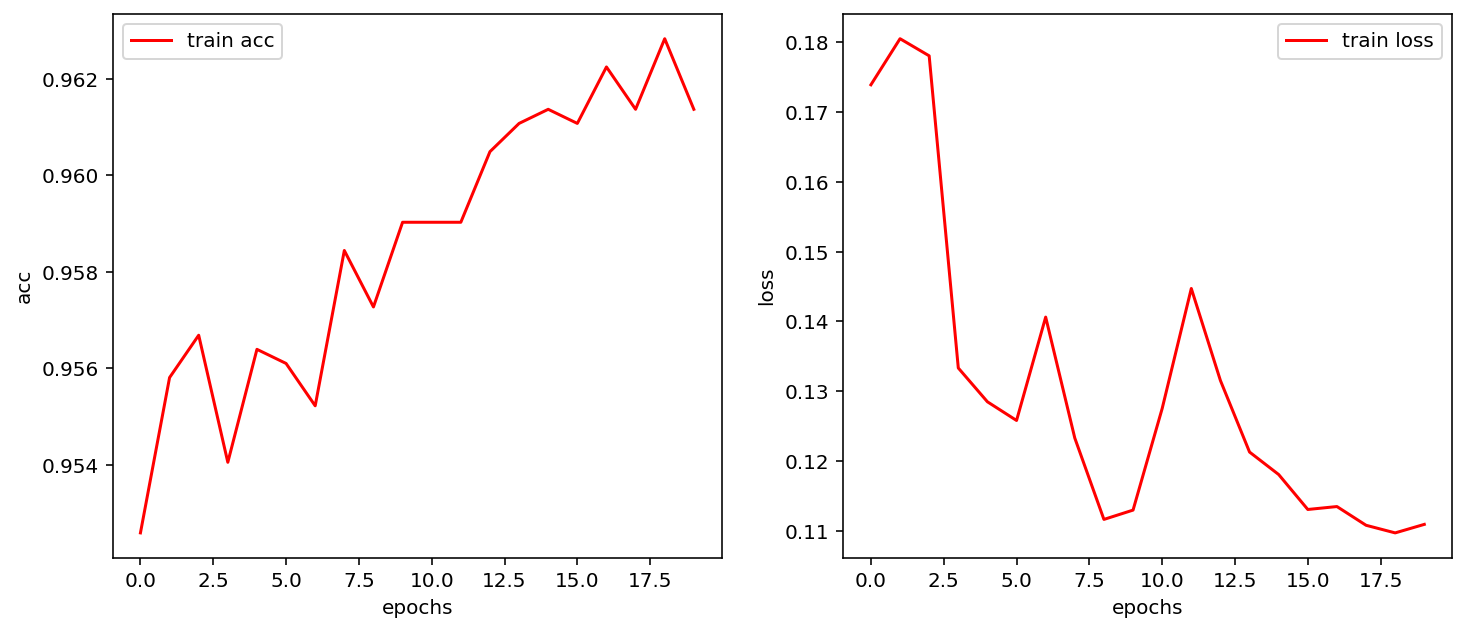

In [ ]:
## 将模型的结果可视化
model_accdf_fin1 = pd.DataFrame(modelfin1.history)
model_accdf_fin1["epochs"] = modelfin1.epoch
model_accdf_fin1.head()
print(model_accdf_fin1)
## 可视化acc 和loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(model_accdf_fin1.epochs,model_accdf_fin1.acc,"r-",label = "train acc")
#plt.plot(model_accdf_fin2.epochs,model_accdf_fin2.val_acc,"b--",label = "val acc")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("acc")
plt.subplot(1,2,2)
plt.plot(model_accdf_fin1.epochs,model_accdf_fin1.loss,"r-",label = "train loss")
#plt.plot(model_accdf_fin2.epochs,model_accdf_fin2.val_loss,"b--",label = "val loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
K.set_learning_phase(0)
base_model2 = keras.applications.resnet50.ResNet50(input_shape = (224,224,3), 
                                              weights="imagenet", 
                                              include_top=False)
K.set_learning_phase(1)
base_model2.summary()


/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
test_featuresvgg2, test_labelsvgg2 = extract_features(base_model2,5229, train_data,(7,7,2048),2)

 Extracting features from batch 82 / 82 -- run time: 117.49132966995239 seconds



In [ ]:
features2 = np.reshape(test_featuresvgg2, (5229, -1))
#np.save("/content/drive/MyDrive/outputs/train_Resnet50features.npy",test_features2)

In [ ]:
#K.set_learning_phase(1)
model2=Sequential()
model2.add(base_model2)
model2.add(tf.keras.layers.GlobalAveragePooling2D())
#model2.add(Dense(512,activation="relu",input_dim=test_features1.shape[1],name = "fu_1")) 
model2.add(tf.keras.layers.Dense(512,activation="relu"))
#model.add(tf.keras.layers.Dense(512,activation="relu",kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model2.add(tf.keras.layers.Dense(2,activation="sigmoid"))


In [ ]:
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),loss="binary_crossentropy",metrics=["acc"])
model_fit2=model2.fit(train_data,
                      batch_size=32,
                      shuffle=True,#validation_split=0.1,  ## 使用百分之10作为验证集
                      epochs=15, verbose=0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


        loss       acc  epochs
0   0.232022  0.900172       0
1   0.095541  0.968445       1
2   0.071425  0.974565       2
3   0.066712  0.977242       3
4   0.054458  0.980493       4
5   0.044670  0.984509       5
6   0.044796  0.983745       6
7   0.040636  0.987378       7
8   0.031225  0.989290       8
9   0.043257  0.984701       9
10  0.023569  0.990820      10
11  0.035418  0.990055      11
12  0.027714  0.990247      12
13  0.031022  0.991585      13
14  0.019246  0.993880      14


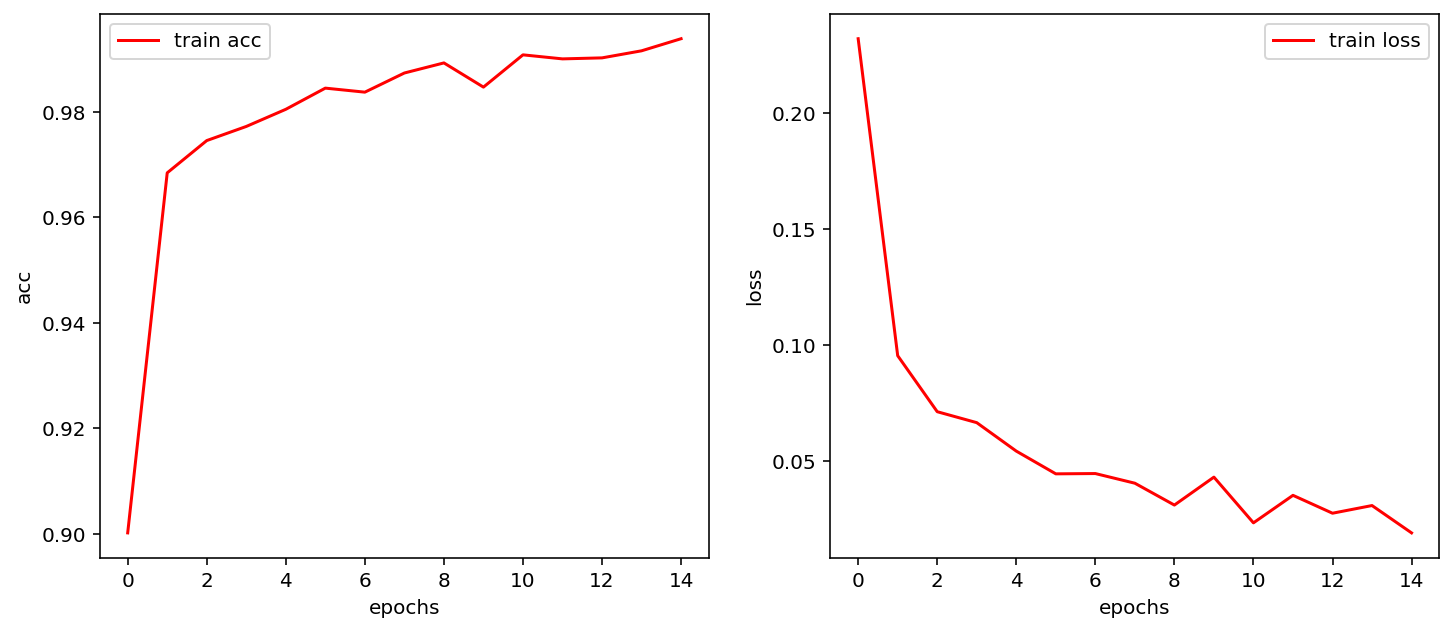

In [ ]:
## 将模型的结果可视化
model_accdf2 = pd.DataFrame(model_fit2.history)
model_accdf2["epochs"] = model_fit2.epoch
model_accdf2.head()

print(model_accdf2)

## 可视化acc 和loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(model_accdf2.epochs,model_accdf2.acc,"r-",label = "train acc")
#plt.plot(model_accdf2.epochs,model_accdf2.val_acc,"b--",label = "val acc")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("acc")
plt.subplot(1,2,2)
plt.plot(model_accdf2.epochs,model_accdf2.loss,"r-",label = "train loss")
#plt.plot(model_accdf2.epochs,model_accdf2.val_loss,"b--",label = "val loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

#print(model_accdf.val_acc[99])
#print(model_accdf.val_loss[99])

In [ ]:
#K.set_learning_phase(1)
model3=Sequential()
#model3.add(base_model2)
#model3.add(tf.keras.layers.GlobalAveragePooling2D())
model3.add(Dense(512,activation="relu",input_dim=features2.shape[1],name = "f_1")) 
#model3.add(tf.keras.layers.Dense(512,activation="relu"))
#model.add(tf.keras.layers.Dense(512,activation="relu",kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model3.add(tf.keras.layers.Dense(2,activation="sigmoid"))

model3.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 f_1 (Dense)                 (None, 512)               51380736  
                                                                 
 dense_4 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 51,381,762
Trainable params: 51,381,762
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model3.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),loss="binary_crossentropy",metrics=["acc"])
model_fit3=model3.fit(features2,test_labelsvgg2,
                      batch_size=32,
                      shuffle=True,validation_split=0.1,  ## 使用百分之10作为验证集
                      epochs=100, verbose=0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


        loss       acc  val_loss   val_acc  epochs
0   0.669591  0.676371  0.560734  0.688336       0
1   0.505891  0.752656  0.566949  0.671128       1
2   0.485184  0.763281  0.551314  0.722753       2
3   0.461371  0.786443  0.524717  0.753346       3
4   0.454054  0.787293  0.440055  0.801147       4
..       ...       ...       ...       ...     ...
95  0.023573  0.998725  0.639959  0.824092      95
96  0.057806  0.981300  0.652398  0.826004      96
97  0.030809  0.992138  0.667249  0.822180      97
98  0.020906  0.998513  0.676221  0.824092      98
99  0.017368  0.999788  0.660183  0.831740      99

[100 rows x 5 columns]


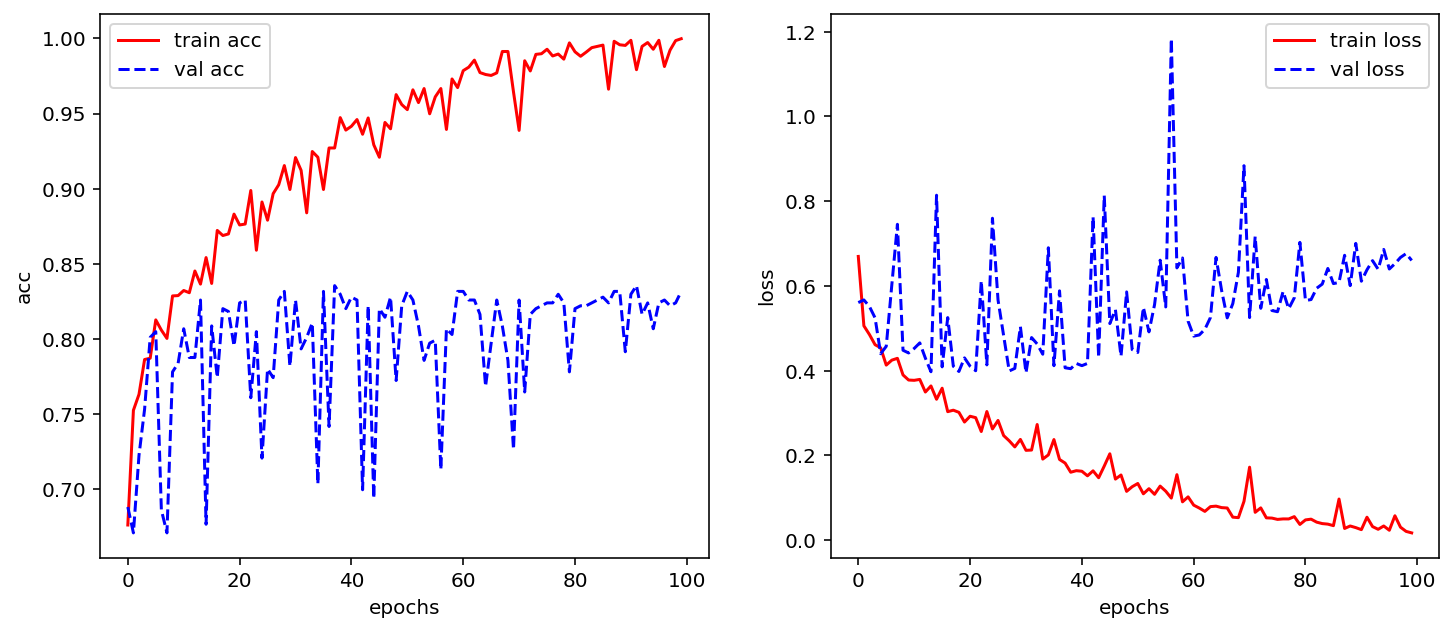

In [ ]:


## 将模型的结果可视化
model_accdf3 = pd.DataFrame(model_fit3.history)
model_accdf3["epochs"] = model_fit3.epoch
model_accdf3.head()
print(model_accdf3)
## 可视化acc 和loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(model_accdf3.epochs,model_accdf3.acc,"r-",label = "train acc")
plt.plot(model_accdf3.epochs,model_accdf3.val_acc,"b--",label = "val acc")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("acc")
plt.subplot(1,2,2)
plt.plot(model_accdf3.epochs,model_accdf3.loss,"r-",label = "train loss")
plt.plot(model_accdf3.epochs,model_accdf3.val_loss,"b--",label = "val loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

#print(model_accdf.val_accuracy[99])
#print(model_accdf.val_loss[99])

In [ ]:
inputs = tf.keras.layers.Input(shape=(224,224,3))
combined = tf.keras.layers.Concatenate()([model2(inputs), model4(inputs)])
outputs = tf.keras.layers.Dense(2,activation="relu")(combined)

model_fin2= tf.keras.models.Model(inputs, outputs)

In [ ]:
#print(output)

[[1.1195598 0.       ]
 [1.1195463 0.       ]
 [1.1203063 0.       ]
 ...
 [1.1194214 0.       ]
 [1.119412  0.       ]
 [1.1195424 0.       ]]


In [ ]:
model4.trainable = False
model2.trainable = False

model_fin2.compile(Adam(lr=0.01),loss="categorical_crossentropy", metrics=["acc"])
modelfin2= model_fin2.fit(test_data,epochs=15, verbose=0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


        loss       acc  epochs
0   0.153274  0.968393       0
1   0.152022  0.968393       1
2   0.149255  0.966930       2
3   0.147945  0.966930       3
4   0.157211  0.967808       4
5   0.152349  0.966637       5
6   0.151758  0.966345       6
7   0.148594  0.966930       7
8   0.152762  0.966345       8
9   0.152227  0.966637       9
10  0.148314  0.966637      10
11  0.141894  0.966637      11
12  0.133419  0.966637      12
13  0.144926  0.966345      13
14  0.134831  0.966345      14


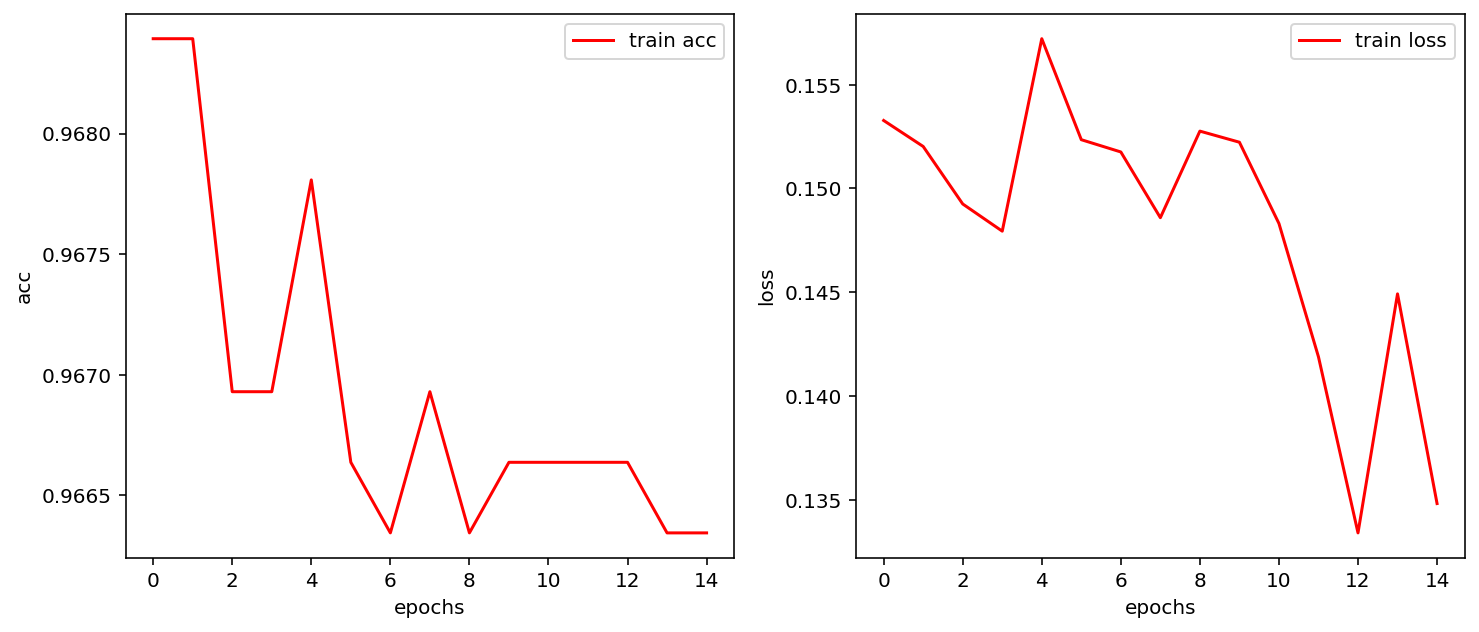

In [ ]:

## 将模型的结果可视化
model_accdf_fin2 = pd.DataFrame(modelfin2.history)
model_accdf_fin2["epochs"] = modelfin2.epoch
model_accdf_fin2.head()
print(model_accdf_fin2)
## 可视化acc 和loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(model_accdf_fin2.epochs,model_accdf_fin2.acc,"r-",label = "train acc")
#plt.plot(model_accdf_fin2.epochs,model_accdf_fin2.val_acc,"b--",label = "val acc")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("acc")
plt.subplot(1,2,2)
plt.plot(model_accdf_fin2.epochs,model_accdf_fin2.loss,"r-",label = "train loss")
#plt.plot(model_accdf_fin2.epochs,model_accdf_fin2.val_loss,"b--",label = "val loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
model4.trainable = False
model2.trainable = False

model_fin2.compile(Adam(lr=0.01),loss="categorical_crossentropy", metrics=["acc"])
modelfin2_20e= model_fin2.fit(test_data,epochs=20, verbose=0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


        loss       acc  epochs
0   0.120735  0.966637       0
1   0.107068  0.965174       1
2   0.109987  0.965759       2
3   0.103510  0.966345       3
4   0.153632  0.966345       4
5   0.142698  0.964296       5
6   0.134136  0.963126       6
7   0.129301  0.962833       7
8   0.126027  0.962540       8
9   0.122874  0.963126       9
10  0.120453  0.962833      10
11  0.119159  0.961955      11
12  0.117253  0.962833      12
13  0.115920  0.962833      13
14  0.114963  0.962833      14
15  0.113775  0.962248      15
16  0.112493  0.963126      16
17  0.111520  0.962833      17
18  0.110332  0.962540      18
19  0.110085  0.962833      19


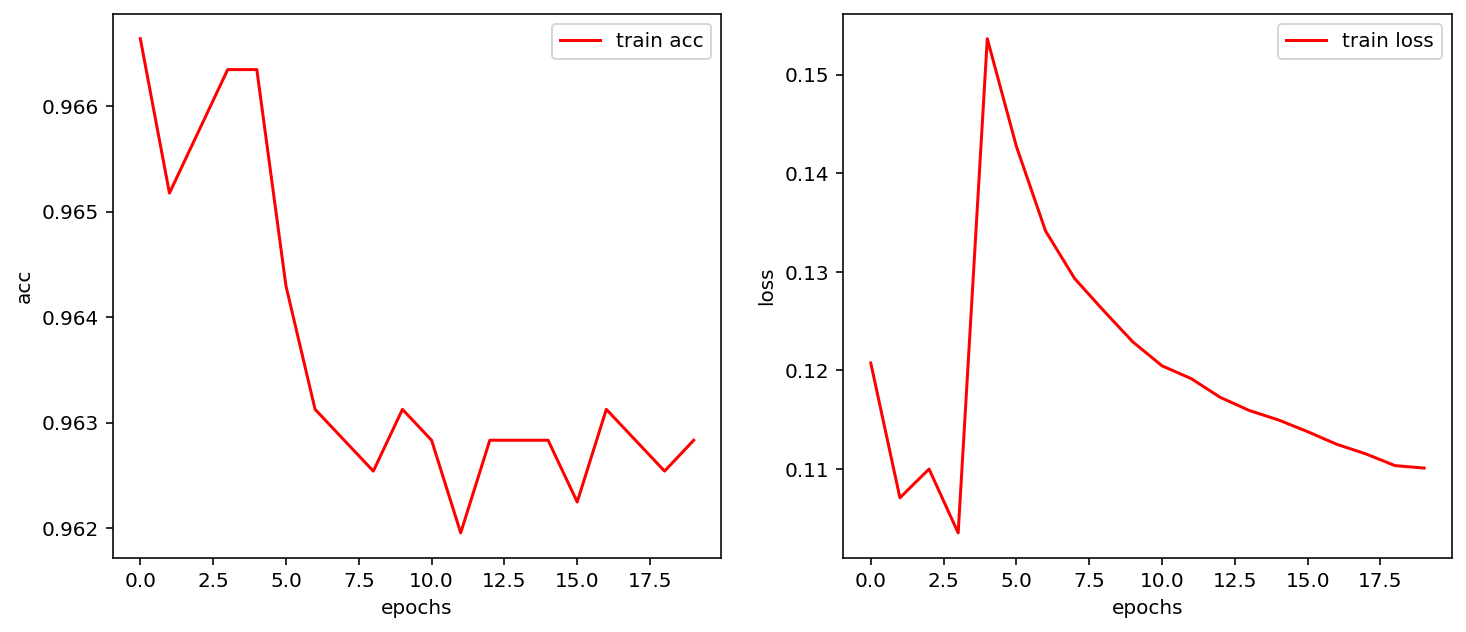

In [ ]:
## 将模型的结果可视化
model_accdf_fin2_20e = pd.DataFrame(modelfin2_20e.history)
model_accdf_fin2_20e["epochs"] = modelfin2_20e.epoch
model_accdf_fin2_20e.head()
print(model_accdf_fin2_20e)
## 可视化acc 和loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(model_accdf_fin2_20e.epochs,model_accdf_fin2_20e.acc,"r-",label = "train acc")
#plt.plot(model_accdf_fin2.epochs,model_accdf_fin2.val_acc,"b--",label = "val acc")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("acc")
plt.subplot(1,2,2)
plt.plot(model_accdf_fin2_20e.epochs,model_accdf_fin2_20e.loss,"r-",label = "train loss")
#plt.plot(model_accdf_fin2.epochs,model_accdf_fin2.val_loss,"b--",label = "val loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
inputs = tf.keras.layers.Input(shape=(224,224,3))
combined = tf.keras.layers.Concatenate()([model2(inputs), model2(inputs)])
outputs = tf.keras.layers.Dense(2,activation="relu")(combined)

model_fin3= tf.keras.models.Model(inputs, outputs)

In [ ]:
#model4.trainable = False
model2.trainable = False

model_fin3.compile(Adam(lr=0.01),loss="categorical_crossentropy", metrics=["acc"])
modelfin3=model_fin3.fit(test_data,epochs = 20)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
54/54 [==============================] - 42s 675ms/step - loss: 8.8683 - acc: 0.2766
Epoch 2/20
54/54 [==============================] - 36s 662ms/step - loss: 0.3109 - acc: 0.9631
Epoch 3/20
54/54 [==============================] - 39s 705ms/step - loss: 0.2613 - acc: 0.9643
Epoch 4/20
54/54 [==============================] - 37s 685ms/step - loss: 0.2271 - acc: 0.9652
Epoch 5/20
54/54 [==============================] - 36s 663ms/step - loss: 0.2270 - acc: 0.9655
Epoch 6/20
54/54 [==============================] - 37s 669ms/step - loss: 0.2269 - acc: 0.9652
Epoch 7/20
54/54 [==============================] - 38s 691ms/step - loss: 0.2593 - acc: 0.9663
Epoch 8/20
54/54 [==============================] - 37s 669ms/step - loss: 0.2272 - acc: 0.9649
Epoch 9/20
54/54 [==============================] - 37s 687ms/step - loss: 0.2271 - acc: 0.9652
Epoch 10/20
54/54 [==============================] - 36s 667ms/step - loss: 0.2270 - acc: 0.9655
Epoch 11/20
54/54 [====================

        loss       acc  epochs
0   8.868294  0.276558       0
1   0.310895  0.963126       1
2   0.261291  0.964296       2
3   0.227067  0.965174       3
4   0.227023  0.965467       4
5   0.226936  0.965174       5
6   0.259258  0.966345       6
7   0.227223  0.964881       7
8   0.227070  0.965174       8
9   0.227004  0.965467       9
10  0.226930  0.965467      10
11  0.226860  0.965467      11
12  0.226950  0.965759      12
13  0.226873  0.965467      13
14  0.226907  0.966345      14
15  0.226923  0.965467      15
16  0.226849  0.966345      16
17  0.226758  0.966052      17
18  0.226995  0.966345      18
19  0.226706  0.966637      19


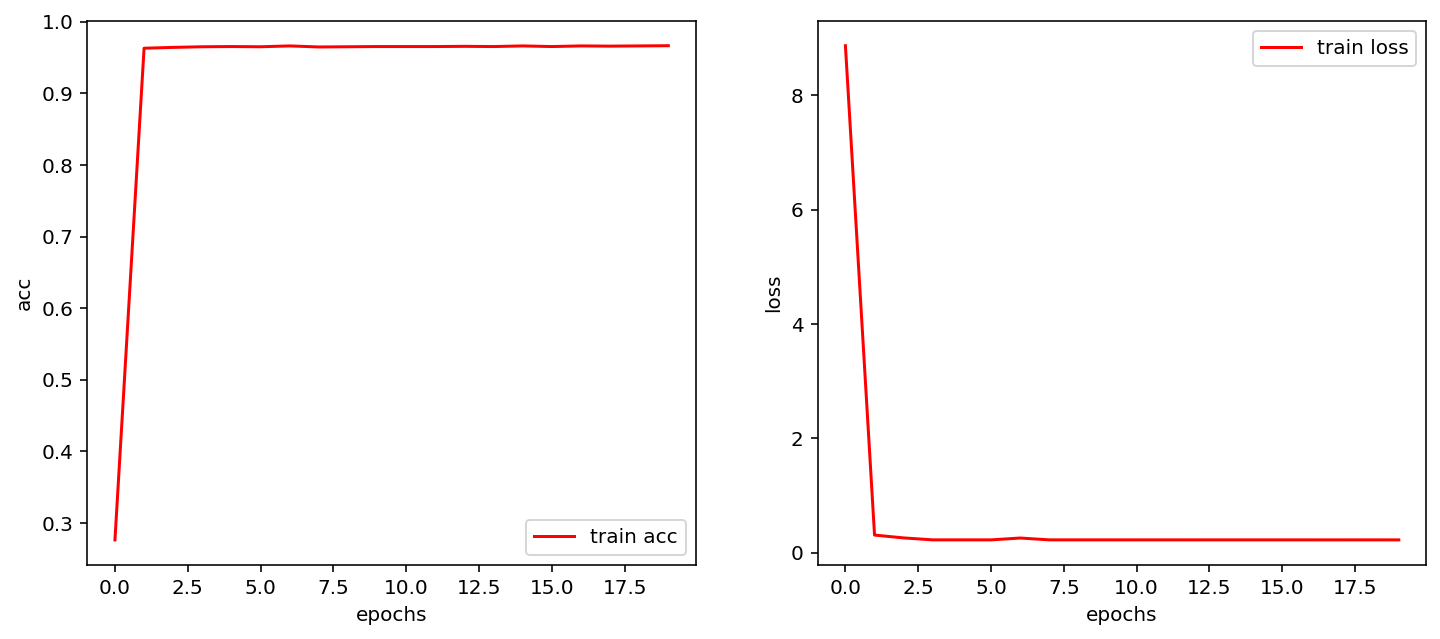

In [ ]:
## 将模型的结果可视化
model_accdf_fin3 = pd.DataFrame(modelfin3.history)
model_accdf_fin3["epochs"] = modelfin3.epoch
model_accdf_fin3.head()
print(model_accdf_fin3)
## 可视化acc 和loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(model_accdf_fin3.epochs,model_accdf_fin3.acc,"r-",label = "train acc")
#plt.plot(model_accdf_fin2.epochs,model_accdf_fin2.val_acc,"b--",label = "val acc")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("acc")
plt.subplot(1,2,2)
plt.plot(model_accdf_fin3.epochs,model_accdf_fin3.loss,"r-",label = "train loss")
#plt.plot(model_accdf_fin2.epochs,model_accdf_fin2.val_loss,"b--",label = "val loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Make Images

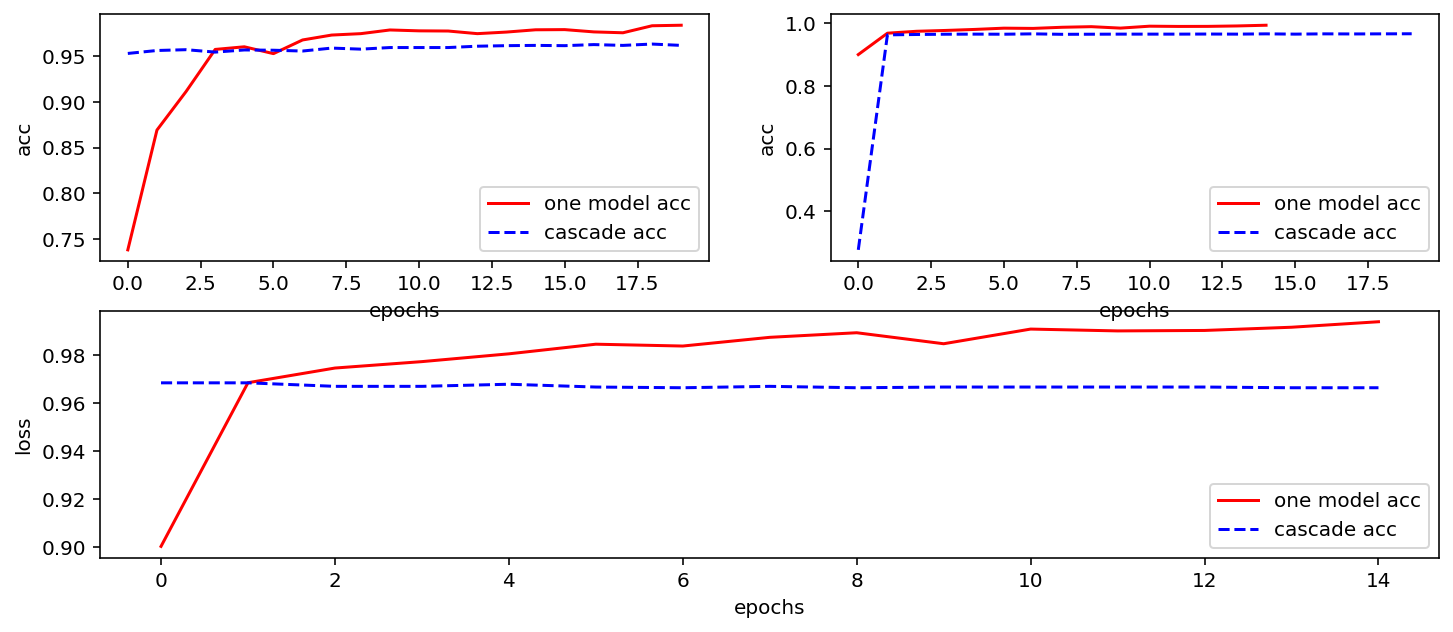

In [ ]:

## 可视化acc 
plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.plot(model_accdf4.epochs,model_accdf4.acc,"r-",label = "one model acc")
plt.plot(model_accdf_fin2_20e.epochs,model_accdf_fin2_20e.acc,"b--",label = "cascade acc")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("acc")
plt.subplot(2,1,2)
plt.plot(model_accdf2.epochs,model_accdf2.acc,"r-",label = "one model acc")
plt.plot(model_accdf_fin2.epochs,model_accdf_fin2.acc,"b--",label = "cascade acc")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.subplot(2,2,1)
plt.plot(model_accdf4.epochs,model_accdf4.acc,"r-",label = "one model acc")
plt.plot(model_accdf_fin1.epochs,model_accdf_fin1.acc,"b--",label = "cascade acc")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("acc")

plt.subplot(2,2,2)
plt.plot(model_accdf2.epochs,model_accdf2.acc,"r-",label = "one model acc")
plt.plot(model_accdf_fin3.epochs,model_accdf_fin3.acc,"b--",label = "cascade acc")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

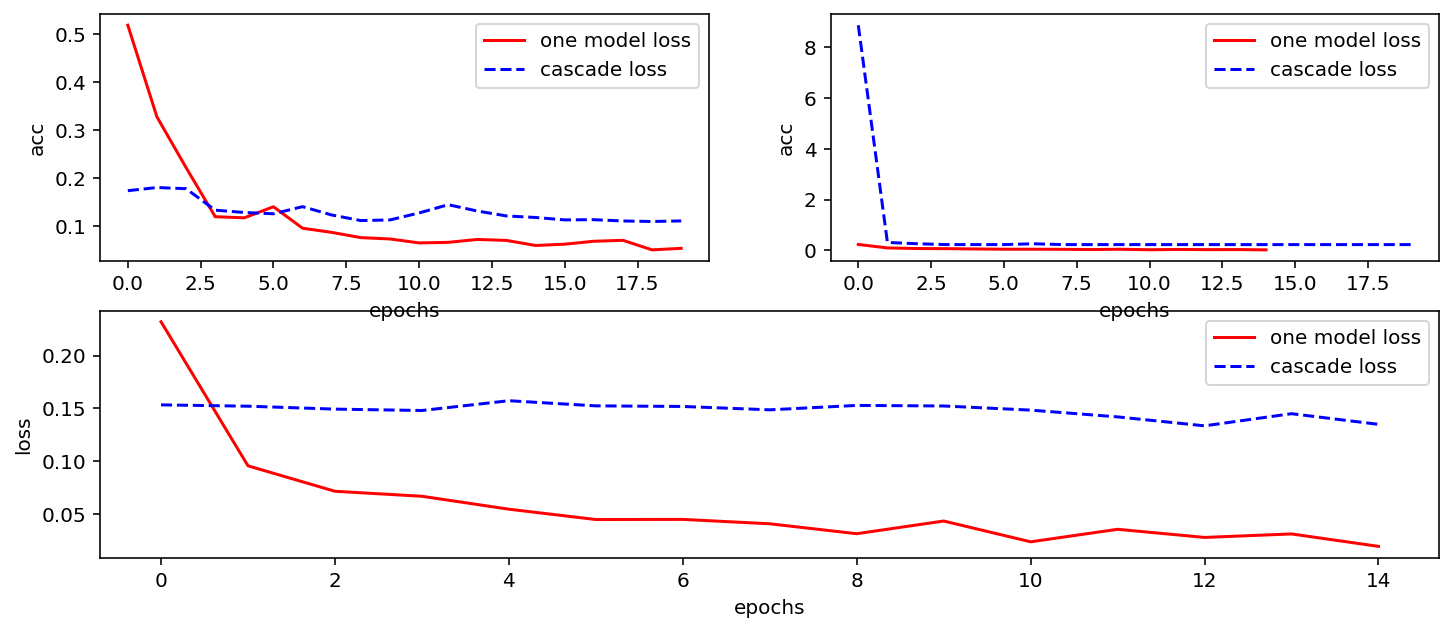

In [ ]:
## 可视化loss
plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.plot(model_accdf4.epochs,model_accdf4.loss,"r-",label = "one model loss")
plt.plot(model_accdf_fin2_20e.epochs,model_accdf_fin2_20e.loss,"b--",label = "cascade loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("acc")
plt.subplot(2,1,2)
plt.plot(model_accdf2.epochs,model_accdf2.loss,"r-",label = "one model loss")
plt.plot(model_accdf_fin2.epochs,model_accdf_fin2.loss,"b--",label = "cascade loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.subplot(2,2,1)
plt.plot(model_accdf4.epochs,model_accdf4.loss,"r-",label = "one model loss")
plt.plot(model_accdf_fin1.epochs,model_accdf_fin1.loss,"b--",label = "cascade loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("acc")

plt.subplot(2,2,2)
plt.plot(model_accdf2.epochs,model_accdf2.loss,"r-",label = "one model loss")
plt.plot(model_accdf_fin3.epochs,model_accdf_fin3.loss,"b--",label = "cascade loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()